In [ ]:
# !pip install opencv-python
# !pip install yattag


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# =============================================
# DQN for SnakeGame (Full Training, 3000 episodes)
# Metrics: Sample Efficiency, Exploration, Runtime, Convergence & Stability, Policy Behavior
# Includes gameplay recording of best episode
# This notebook mirrors your Q-learning notebook 1:1 in structure and reporting.
# =============================================

# -----------------------
# 0. Imports
# -----------------------
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import os
import warnings
warnings.filterwarnings("ignore")  # ⚙️ Keep output clean during long runs

# environment
from snake_gym.envs import snake
from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT

# DQN libs (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim

# optional: video & html
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    _HAS_CV2 = False

from yattag import Doc, indent


pygame 2.6.1 (SDL 2.28.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# -----------------------
# 1. Environment Setup
# -----------------------
env = snake.SnakeGame()
n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT
dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}



In [4]:
# -----------------------
# 2. State Representation
# -----------------------
def get_state(env):
    """Simplified symbolic state: (dx, dy, direction)"""
    head_x, head_y = env.snake.get_head_position()
    apple_x, apple_y = env.apple.position
    dx = int(np.sign(apple_x - head_x))
    dy = int(np.sign(apple_y - head_y))
    direction = dir_to_int[env.snake.direction]
    return (dx, dy, direction)

def state_to_array(state_tuple):
    return np.array(state_tuple, dtype=np.float32)


In [5]:
# -----------------------
# 3. Hyperparameters
# -----------------------
episodes = 3000  # ⏳ Full training run (match Q-learning)
gamma = 0.9
epsilon_init = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
# DQN-specific
lr = 1e-3
batch_size = 64
replay_capacity = 10000
target_update_freq = 100   # update target net every 100 episodes
checkpoint_freq = 1000     # save checkpoint every 1000 episodes
log_freq = 100             # print every 100 episodes
hidden_size = 64           # Option A: 64x64 MLP (kept small to match tabular complexity)


In [6]:
# -----------------------
# 4. Multi-run Setup for Convergence
# -----------------------
seeds = [42, 123, 999]
all_rewards = []
all_epsilons = []
all_steps = []
runtime_per_seed = []

# -----------------------
# Helpers: model + replay buffer
# -----------------------
class DQNNet(nn.Module):
    def __init__(self, input_dim=3, hidden=64, output_dim=4):
        super(DQNNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        from collections import deque
        self.buf = deque(maxlen=capacity)
    def push(self, s,a,r,s2,d):
        self.buf.append((s,a,r,s2,d))
    def sample(self, n):
        import random
        batch = random.sample(self.buf, n)
        s,a,r,s2,d = zip(*batch)
        return (np.array(s), np.array(a), np.array(r, dtype=np.float32),
                np.array(s2), np.array(d, dtype=np.float32))
    def __len__(self):
        return len(self.buf)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [7]:
# ==========================
# DQN Training Loop with Metrics
# ==========================

import pickle
import torch
import numpy as np
import random
import time
from collections import deque

# Assume seeds, episodes, epsilon_init, epsilon_decay, epsilon_min, etc. are defined
# Also assume env, DQNNet, ReplayBuffer, device, and other DQN settings are defined

all_rewards_dqn = []
all_epsilons_dqn = []
all_steps_dqn = []
runtime_per_seed_dqn = []

for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize policy and target networks
    policy_net = DQNNet(input_dim=3, hidden=hidden_size, output_dim=n_actions).to(device)
    target_net = DQNNet(input_dim=3, hidden=hidden_size, output_dim=n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer(capacity=replay_capacity)

    rewards_per_episode = []
    moving_avg_rewards = deque(maxlen=10)
    epsilons = []
    steps_per_episode = []

    epsilon = epsilon_init
    start_time = time.time()

    for episode in range(episodes):
        env.reset()
        state = get_state(env)
        state_arr = state_to_array(state)
        done = False
        total_reward = 0.0
        steps = 0

        while not done:
            if random.random() < epsilon:
                action = random.randrange(n_actions)
            else:
                with torch.no_grad():
                    st = torch.tensor(state_arr, dtype=torch.float32, device=device).unsqueeze(0)
                    qvals = policy_net(st)
                    action = int(torch.argmax(qvals).item())

            frame, reward, done, _ = env.step(action)
            next_state = get_state(env)
            next_state_arr = state_to_array(next_state)

            memory.push(state_arr, action, reward, next_state_arr, done)
            state_arr = next_state_arr
            total_reward += reward
            steps += 1

            # DQN update
            if len(memory) >= batch_size:
                s_batch, a_batch, r_batch, s2_batch, d_batch = memory.sample(batch_size)
                s_t = torch.tensor(s_batch, dtype=torch.float32, device=device)
                a_t = torch.tensor(a_batch, dtype=torch.long, device=device)
                r_t = torch.tensor(r_batch, dtype=torch.float32, device=device)
                s2_t = torch.tensor(s2_batch, dtype=torch.float32, device=device)
                d_t = torch.tensor(d_batch, dtype=torch.float32, device=device)

                q_values = policy_net(s_t).gather(1, a_t.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q = target_net(s2_t).max(1)[0]
                    target_q = r_t + gamma * next_q * (1 - d_t)
                loss = torch.nn.MSELoss()(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # End episode bookkeeping
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        moving_avg_rewards.append(total_reward)
        epsilons.append(epsilon)
        steps_per_episode.append(steps)

        # Print progress
        if (episode + 1) % log_freq == 0:
            avg_reward = np.mean(moving_avg_rewards) if len(moving_avg_rewards) > 0 else 0.0
            print(f"Seed {seed} | Episode {episode+1}/{episodes} | Avg Reward (last {len(moving_avg_rewards)}): {avg_reward:.2f} | ε={epsilon:.3f}")

        # Checkpoint and save metrics
        if (episode + 1) % checkpoint_freq == 0:
            torch.save(policy_net.state_dict(), f"checkpoint_dqn_seed_{seed}_ep_{episode+1}.pth")
            with open(f"rewards_dqn_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(rewards_per_episode, f)
            with open(f"epsilons_dqn_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(epsilons, f)
            with open(f"steps_dqn_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(steps_per_episode, f)
            print(f"💾 Checkpoint & metrics saved at episode {episode+1}")

        # Update target network periodically
        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # End of seed
    end_time = time.time()
    avg_time_per_episode = (end_time - start_time) / episodes
    runtime_per_seed_dqn.append(avg_time_per_episode)

    all_rewards.append(rewards_per_episode)
    all_epsilons.append(epsilons)
    all_steps.append(steps_per_episode)

    # Save final model and metrics
    torch.save(policy_net.state_dict(), f"dqn_model_seed_{seed}.pth")
    with open(f"rewards_dqn_seed_{seed}.pkl", "wb") as f:
        pickle.dump(rewards_per_episode, f)
    with open(f"epsilons_dqn_seed_{seed}.pkl", "wb") as f:
        pickle.dump(epsilons, f)
    with open(f"steps_dqn_seed_{seed}.pkl", "wb") as f:
        pickle.dump(steps_per_episode, f)
    print(f"✅ DQN model & metrics saved for seed {seed}")


Seed 42 | Episode 100/3000 | Avg Reward (last 10): 7.93 | ε=0.606
Seed 42 | Episode 200/3000 | Avg Reward (last 10): 15.20 | ε=0.367
Seed 42 | Episode 300/3000 | Avg Reward (last 10): 23.72 | ε=0.222
Seed 42 | Episode 400/3000 | Avg Reward (last 10): 49.87 | ε=0.135
Seed 42 | Episode 500/3000 | Avg Reward (last 10): 43.36 | ε=0.082
Seed 42 | Episode 600/3000 | Avg Reward (last 10): 64.92 | ε=0.050
Seed 42 | Episode 700/3000 | Avg Reward (last 10): 74.86 | ε=0.050
Seed 42 | Episode 800/3000 | Avg Reward (last 10): 89.14 | ε=0.050
Seed 42 | Episode 900/3000 | Avg Reward (last 10): 79.96 | ε=0.050
Seed 42 | Episode 1000/3000 | Avg Reward (last 10): 73.87 | ε=0.050
💾 Checkpoint & metrics saved at episode 1000
Seed 42 | Episode 1100/3000 | Avg Reward (last 10): 59.41 | ε=0.050
Seed 42 | Episode 1200/3000 | Avg Reward (last 10): 93.08 | ε=0.050
Seed 42 | Episode 1300/3000 | Avg Reward (last 10): 52.03 | ε=0.050
Seed 42 | Episode 1400/3000 | Avg Reward (last 10): 71.90 | ε=0.050
Seed 42 | Epi

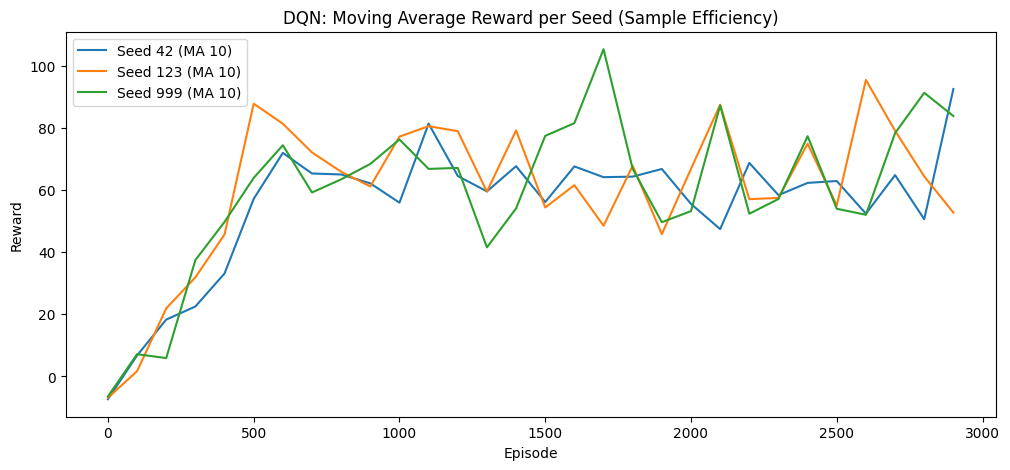

Episodes to reach 50%, 80%, 90% of max reward per seed:
Seed 42: {'50%': 418, '80%': 641, '90%': 1569}
Seed 123: {'50%': 414, '80%': 804, '90%': 806}
Seed 999: {'50%': 396, '80%': 721, '90%': 1701}


In [13]:
# -----------------------
# 6. Sample Efficiency (DQN)
# -----------------------
import numpy as np
import matplotlib.pyplot as plt

ma_window = 10  # moving average window
downsample = 100  # plot every N episodes

# For storing episode numbers to reach thresholds
episodes_to_thresholds = {seed: {} for seed in seeds}
thresholds = [0.5, 0.8, 0.9]  # 50%, 80%, 90%

plt.figure(figsize=(12,5))

for i, rewards in enumerate(all_rewards):
    # Compute moving average
    if len(rewards) < ma_window:
        ma = np.array(rewards)
    else:
        ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
    
    max_reward = np.max(ma)
    
    # Find first episode reaching each threshold
    for t in thresholds:
        target = t * max_reward
        episode_idx = next((idx for idx, r in enumerate(ma) if r >= target), None)
        episodes_to_thresholds[seeds[i]][f"{int(t*100)}%"] = episode_idx
    
    # Downsample for plotting
    x = np.arange(len(ma))
    x_ds = x[::downsample]
    ma_ds = ma[::downsample]
    
    plt.plot(x_ds, ma_ds, label=f"Seed {seeds[i]} (MA {ma_window})")

plt.title("DQN: Moving Average Reward per Seed (Sample Efficiency)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Print summary table
print("Episodes to reach 50%, 80%, 90% of max reward per seed:")
for seed, data in episodes_to_thresholds.items():
    print(f"Seed {seed}: {data}")


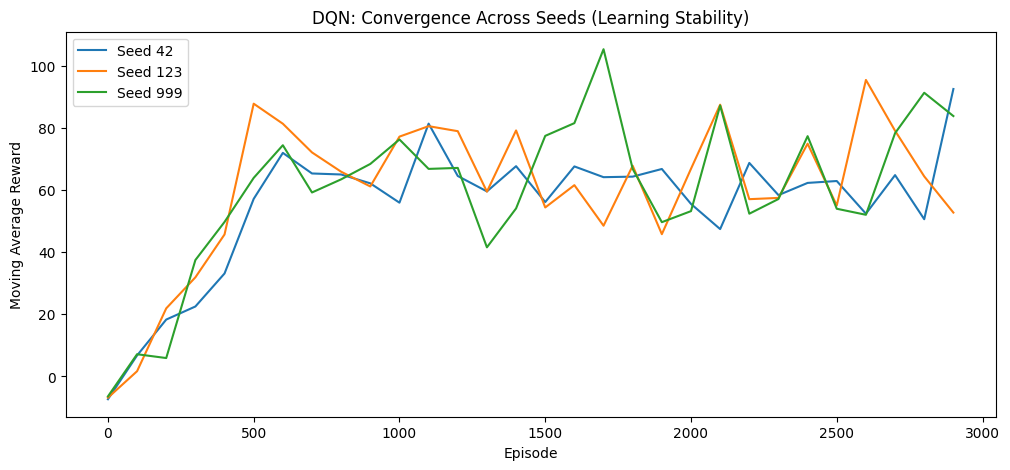

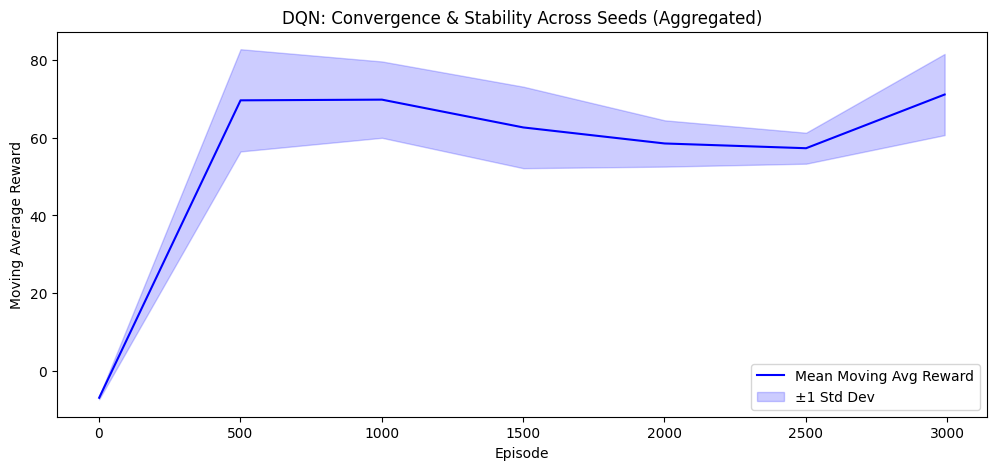

DQN Convergence & Stability Table (Exact Downsampled Values):
      Seed 42  Seed 123  Seed 999   Mean  StdDev
1       -7.34     -6.85     -6.44  -6.88    0.37
501     57.14     87.77     63.89  69.60   13.14
1001    55.91     77.17     76.25  69.78    9.81
1501    56.11     54.37     77.41  62.63   10.48
2001    55.51     66.82     53.19  58.51    5.95
2501    62.88     55.02     53.96  57.29    3.98
2991    65.20     62.33     85.75  71.09   10.43


In [19]:
# -----------------------
# 7. Convergence & Stability Visualization (DQN)
# -----------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ma_window = 10
downsample = 100  # downsample for aggregated plot


# -----------------------
# Convergence Across Seeds (DQN)
# -----------------------
plt.figure(figsize=(12,5))
for i, rewards in enumerate(all_rewards):  # use DQN rewards here
    if len(rewards) < ma_window:
        ma = np.array(rewards)
    else:
        ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
    
    # Downsample for plotting
    x = np.arange(len(ma))
    x_ds = x[::downsample]
    ma_ds = ma[::downsample]
    
    plt.plot(x_ds, ma_ds, label=f"Seed {seeds[i]}")

plt.title("DQN: Convergence Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.legend()
plt.show()

ma_window = 10
downsample = 500
# -----------------------
# Aggregate Mean & Std Across Seeds (Downsampled)
# -----------------------
all_ma = []
for rewards in all_rewards:
    if len(rewards) < ma_window:
        ma = np.array(rewards)
    else:
        ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
    all_ma.append(ma)

if all_ma:
    min_len = min(len(ma) for ma in all_ma)
    x_ds = np.arange(0, min_len, downsample)
    if (min_len-1) not in x_ds:
        x_ds = np.append(x_ds, min_len-1)
    
    all_ma_trunc = [ma[x_ds] for ma in all_ma]
    episodes_axis_ds = x_ds + 1  # 1-indexed

    mean_ma = np.mean(all_ma_trunc, axis=0)
    std_ma = np.std(all_ma_trunc, axis=0)

    plt.figure(figsize=(12,5))
    plt.plot(episodes_axis_ds, mean_ma, label="Mean Moving Avg Reward", color="blue")
    plt.fill_between(episodes_axis_ds, mean_ma - std_ma, mean_ma + std_ma,
                     color="blue", alpha=0.2, label="±1 Std Dev")
    plt.title("DQN: Convergence & Stability Across Seeds (Aggregated)")
    plt.xlabel("Episode")
    plt.ylabel("Moving Average Reward")
    plt.legend()
    plt.show()

    # -----------------------
    # Convergence & Stability Table (Exact Downsampled Values)
    # -----------------------
    table_data = {}
    for i, seed in enumerate(seeds):
        table_data[f"Seed {seed}"] = all_ma_trunc[i]
    table_data["Mean"] = mean_ma
    table_data["StdDev"] = std_ma

    df_convergence_dqn = pd.DataFrame(table_data, index=episodes_axis_ds)
    pd.set_option('display.precision', 2)
    print("DQN Convergence & Stability Table (Exact Downsampled Values):")
    print(df_convergence_dqn)
else:
    print("No DQN rewards to display.")


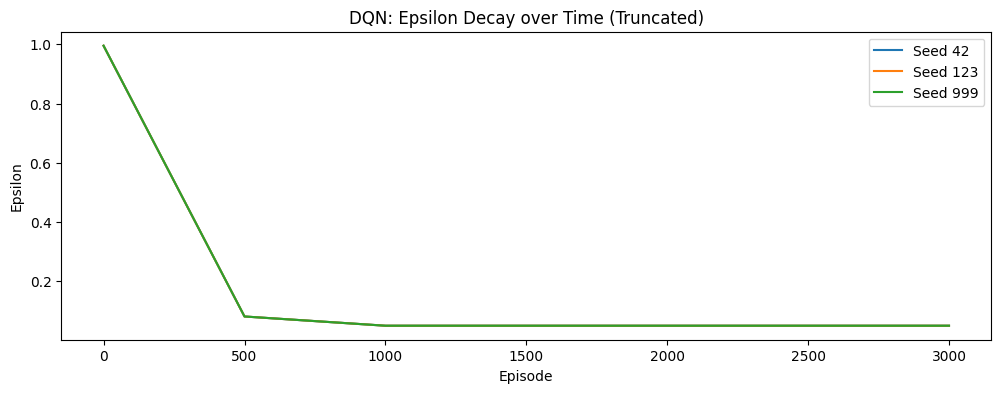


DQN Epsilon Decay Table (Truncated up to 3000):
   Episode  Seed 42  Seed 123  Seed 999
0        0     0.99      0.99      0.99
1      500     0.08      0.08      0.08
2     1000     0.05      0.05      0.05
3     1500     0.05      0.05      0.05
4     2000     0.05      0.05      0.05
5     2500     0.05      0.05      0.05
6     2999     0.05      0.05      0.05


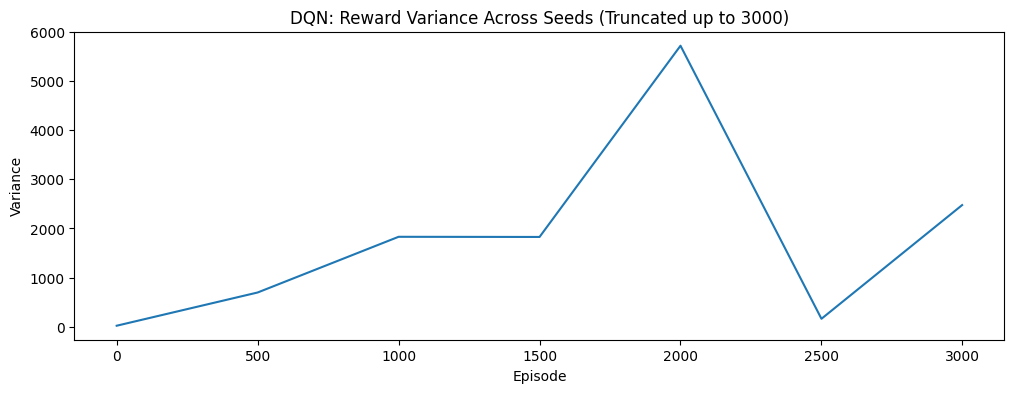


DQN Reward Variance Table (Truncated up to 3000):
   Episode  Reward Variance
0        0            21.48
1      500           697.34
2     1000          1830.21
3     1500          1827.05
4     2000          5716.89
5     2500           162.62
6     2999          2475.42


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 8. Exploration Stability (DQN, Truncated)
# -----------------------

truncate_every = 500  # downsample episodes for plotting and table
max_episode = 3000    # ensure table and plots include up to episode 3000

# Use DQN-specific arrays
eps_source = all_epsilons
rewards_source = all_rewards

# --- Epsilon Decay (Truncated) ---
plt.figure(figsize=(12,4))
eps_tables = []
for i, eps in enumerate(eps_source):
    eps_trunc = eps[::truncate_every]
    # Include last episode if not in the truncated array
    if len(eps) >= max_episode and (max_episode-1) not in np.arange(0, len(eps), truncate_every):
        eps_trunc = np.append(eps_trunc, eps[max_episode-1])
    
    eps_table = pd.DataFrame({
        "Episode": np.arange(0, len(eps), truncate_every).tolist() + 
                   ([max_episode-1] if len(eps_trunc) > len(np.arange(0, len(eps), truncate_every)) else []),
        f"Seed {seeds[i]}": eps_trunc
    })
    eps_tables.append(eps_table)
    
    plt.plot(eps_table["Episode"], eps_trunc, label=f"Seed {seeds[i]}")

plt.title("DQN: Epsilon Decay over Time (Truncated)")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

# Merge all epsilon tables into a single table
epsilon_df = eps_tables[0]
for tbl in eps_tables[1:]:
    epsilon_df = pd.merge(epsilon_df, tbl, on="Episode")

print("\nDQN Epsilon Decay Table (Truncated up to 3000):")
print(epsilon_df)

# --- Reward Variance Across Seeds (Truncated) ---
# Pad rewards to equal length
max_len = max(len(r) for r in rewards_source)
padded_rewards = [np.pad(r, (0, max_len - len(r)), 'edge') for r in rewards_source]
reward_variance_across_seeds = np.var(padded_rewards, axis=0)

# Downsample and include last episode
downsample = 500
x_var = np.arange(len(reward_variance_across_seeds))
x_var_ds = x_var[::downsample].tolist()
if len(x_var) >= max_episode and (max_episode-1) not in x_var_ds:
    x_var_ds.append(max_episode-1)

var_ds = reward_variance_across_seeds[x_var_ds]

plt.figure(figsize=(12,4))
plt.plot(x_var_ds, var_ds)
plt.title("DQN: Reward Variance Across Seeds (Truncated up to 3000)")
plt.xlabel("Episode")
plt.ylabel("Variance")
plt.show()

# Create table
reward_var_table = pd.DataFrame({
    "Episode": x_var_ds,
    "Reward Variance": var_ds
})
print("\nDQN Reward Variance Table (Truncated up to 3000):")
print(reward_var_table)


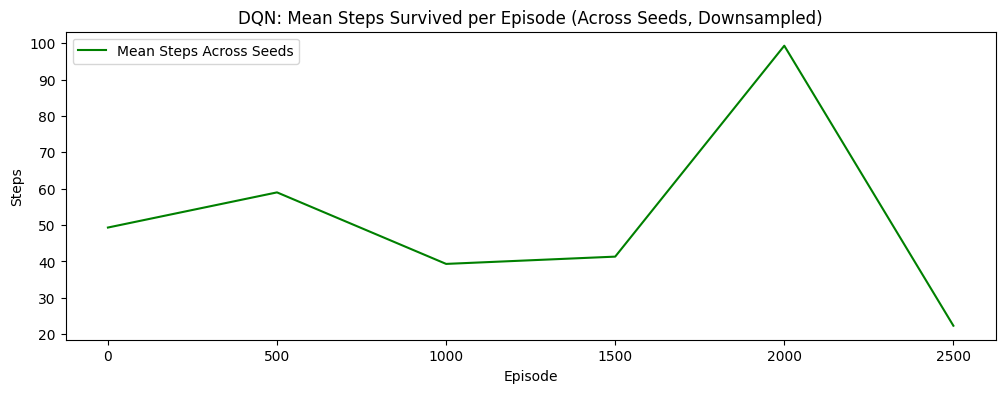


DQN Policy Behavior Table (Mean Steps Across Seeds, Downsampled):
   Episode  Mean Steps
0        0       49.33
1      500       59.00
2     1000       39.33
3     1500       41.33
4     2000       99.33
5     2500       22.33


In [30]:
# -----------------------
# 9. Policy Behavior (Steps Survived) - DQN, Mean Across Seeds
# -----------------------

downsample = 500
plt.figure(figsize=(12,4))

# Collect downsampled steps across seeds
all_steps_ds = [steps[::downsample] for steps in all_steps]
all_steps_ds = np.array(all_steps_ds)
mean_steps = np.mean(all_steps_ds, axis=0)

# X-axis
episodes_ds = np.arange(0, len(all_steps[0]), downsample)

# Plot
plt.plot(episodes_ds, mean_steps, label="Mean Steps Across Seeds", color="green")
plt.title("DQN: Mean Steps Survived per Episode (Across Seeds, Downsampled)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.show()

# Table
policy_behavior_mean_table = pd.DataFrame({
    "Episode": episodes_ds,
    "Mean Steps": mean_steps
})
print("\nDQN Policy Behavior Table (Mean Steps Across Seeds, Downsampled):")
print(policy_behavior_mean_table)


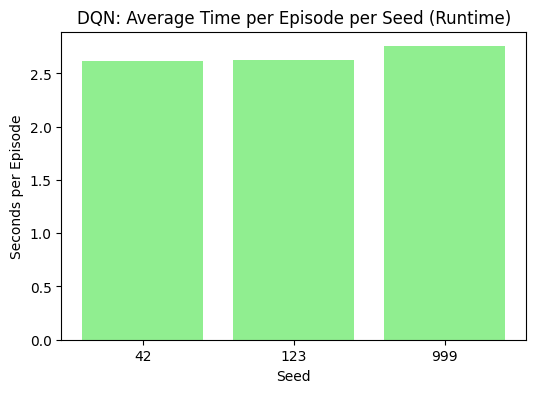


DQN Runtime Table (Average Time per Episode per Seed):
   Seed  Avg Time per Episode (s)
0    42                      2.62
1   123                      2.63
2   999                      2.75


In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 10. Runtime / Computational Efficiency - DQN
# -----------------------

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar([str(s) for s in seeds], runtime_per_seed_dqn, color='lightgreen')
plt.title("DQN: Average Time per Episode per Seed (Runtime)")
plt.xlabel("Seed")
plt.ylabel("Seconds per Episode")
plt.show()

# Create table
runtime_table_dqn = pd.DataFrame({
    "Seed": seeds,
    "Avg Time per Episode (s)": runtime_per_seed_dqn
})

print("\nDQN Runtime Table (Average Time per Episode per Seed):")
print(runtime_table_dqn)


In [42]:
# -----------------------
# High-Level Summary Report (HTML) - DQN
# -----------------------
from yattag import Doc, indent
import numpy as np
import pandas as pd

html_report_dqn = "snake_dqn_summary.html"
doc, tag, text, line = Doc().ttl()

# Compute per-seed metrics
episodes_to_thresholds = []
mean_rewards = []
std_rewards = []
final_epsilons = []
avg_steps = []
avg_runtime = []
raw_max_rewards = []
raw_max_episodes = []
ma_max_rewards = []
ma_max_episodes = []

ma_window = 10  # moving average window

for i, rewards in enumerate(all_rewards):
    # Moving average
    if len(rewards) < ma_window:
        ma = np.array(rewards)
    else:
        ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')

    max_reward_ma = np.max(ma)
    episode_ma = np.argmax(ma) + 1  # +1 if 1-indexed

    max_reward_raw = np.max(rewards)
    episode_raw = np.argmax(rewards) + 1

    # Threshold episodes
    eps_to_50 = next((idx for idx, r in enumerate(ma) if r >= 0.5*max_reward_ma), "N/A")
    eps_to_80 = next((idx for idx, r in enumerate(ma) if r >= 0.8*max_reward_ma), "N/A")
    eps_to_90 = next((idx for idx, r in enumerate(ma) if r >= 0.9*max_reward_ma), "N/A")
    episodes_to_thresholds.append((eps_to_50, eps_to_80, eps_to_90))

    mean_rewards.append(np.mean(rewards))
    std_rewards.append(np.std(rewards))
    final_epsilons.append(all_epsilons[i][-1])
    avg_steps.append(np.mean(all_steps[i]))
    avg_runtime.append(runtime_per_seed_dqn[i])
    raw_max_rewards.append(max_reward_raw)
    raw_max_episodes.append(episode_raw)
    ma_max_rewards.append(max_reward_ma)
    ma_max_episodes.append(episode_ma)

# Best seed by moving average reward
best_seed_idx = np.argmax(ma_max_rewards)
best_seed = seeds[best_seed_idx]
best_ma_reward = ma_max_rewards[best_seed_idx]
best_ma_episode = ma_max_episodes[best_seed_idx]

# Build HTML
with tag('html'):
    with tag('head'):
        line('title', 'Snake DQN High-Level Summary')
        with tag('style'):
            text("""
                table {border-collapse: collapse; width: 80%;}
                th, td {padding: 8px; text-align: center; border: 1px solid black;}
                th {background-color: #f2f2f2;}
                h1, h2 {font-family: Arial, sans-serif;}
            """)
    with tag('body'):
        line('h1', 'Snake DQN High-Level Summary Report')

        # Best seed info
        with tag('h2'):
            text(f"Best Seed by Moving Average Max Reward: Seed {best_seed} | Max MA Reward = {best_ma_reward:.2f} at Episode {best_ma_episode}")

        # Per-seed summary table
        with tag('h2'):
            text("Per-Seed Key Metrics")
        with tag('table'):
            with tag('tr'):
                for col in ["Seed", "Episodes to 50% / 80% / 90% Max Reward",
                            "Mean Reward", "Std Dev Reward", "Final Epsilon",
                            "Avg Steps Survived", "Avg Runtime/Episode (s)",
                            "Raw Max Reward", "Episode of Raw Max Reward",
                            "MA Max Reward", "Episode of MA Max Reward"]:
                    line('th', col)
            for i, seed in enumerate(seeds):
                with tag('tr'):
                    line('td', seed)
                    line('td', f"{episodes_to_thresholds[i][0]} / {episodes_to_thresholds[i][1]} / {episodes_to_thresholds[i][2]}")
                    line('td', f"{mean_rewards[i]:.2f}")
                    line('td', f"{std_rewards[i]:.2f}")
                    line('td', f"{final_epsilons[i]:.3f}")
                    line('td', f"{avg_steps[i]:.2f}")
                    line('td', f"{avg_runtime[i]:.3f}")
                    line('td', f"{raw_max_rewards[i]:.2f}")
                    line('td', f"{raw_max_episodes[i]}")
                    line('td', f"{ma_max_rewards[i]:.2f}")
                    line('td', f"{ma_max_episodes[i]}")

        # Aggregate metrics
        with tag('h2'):
            text("Aggregate Metrics Across Seeds")
        with tag('table'):
            with tag('tr'):
                for col in ["Metric", "Value"]:
                    line('th', col)
            metrics = {
                "Mean of Mean Rewards": np.mean(mean_rewards),
                "Std Dev of Mean Rewards": np.std(mean_rewards),
                "Mean Final Epsilon": np.mean(final_epsilons),
                "Mean Avg Steps Survived": np.mean(avg_steps),
                "Mean Runtime per Episode (s)": np.mean(avg_runtime),
                "Mean Raw Max Reward": np.mean(raw_max_rewards),
                "Mean MA Max Reward": np.mean(ma_max_rewards)
            }
            for k, v in metrics.items():
                with tag('tr'):
                    line('td', k)
                    line('td', f"{v:.3f}")

# Save HTML
with open(html_report_dqn, "w") as f:
    f.write(indent(doc.getvalue()))

print(f"✅ High-Level HTML summary report saved as '{html_report_dqn}'")


✅ High-Level HTML summary report saved as 'snake_dqn_summary.html'


In [45]:
# -----------------------
# Post-Training Evaluation (Greedy Policy) + Combined Video - DQN
# -----------------------
import numpy as np
import torch
import os
import cv2

# 🧠 Load the trained DQN model
seed_to_evaluate = 123  # change to your best-performing seed
model_path = f"dqn_model_seed_{seed_to_evaluate}.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance first
model = DQNNet(input_dim=3, hidden=hidden_size, output_dim=n_actions).to(device)
# Then load the saved state dictionary
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 🎞️ Create output directory
video_dir = f"final_videos_dqn_seed_{seed_to_evaluate}"
os.makedirs(video_dir, exist_ok=True)

eval_episodes = 10
eval_rewards = []
all_frames = []

print(f"\n🎯 Evaluating trained DQN for seed {seed_to_evaluate} (greedy)...\n")

for ep in range(eval_episodes):
    env.reset()
    state = get_state(env)
    state_tensor = torch.tensor(state_to_array(state), dtype=torch.float32).unsqueeze(0).to(device)
    done = False
    total_reward = 0
    frames = []

    while not done:
        # purely greedy — no epsilon
        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        frame, reward, done, _ = env.step(action)
        frames.append(frame)

        # Prepare next state
        next_state = get_state(env)
        state_tensor = torch.tensor(state_to_array(next_state), dtype=torch.float32).unsqueeze(0).to(device)
        total_reward += reward

    eval_rewards.append(total_reward)
    print(f"Eval Episode {ep+1}: Reward = {total_reward:.2f}")

    # Add frames + pause between episodes
    all_frames.extend(frames)
    pause_frame = np.zeros_like(frames[0])
    all_frames.extend([pause_frame]*10)

# 💾 Save all episodes into one stitched video
if len(all_frames) > 0:
    height, width, _ = all_frames[0].shape
    video_filename = os.path.join(video_dir, f"combined_eval_dqn_seed_{seed_to_evaluate}.avi")
    out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))

    for f in all_frames:
        if f.shape[2] == 4:  # convert RGBA → BGR if needed
            f = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
        out.write(f)
    out.release()

# 📊 Save evaluation results
eval_rewards_path = f"eval_rewards_dqn_seed_{seed_to_evaluate}.pkl"
with open(eval_rewards_path, "wb") as f:
    pickle.dump(eval_rewards, f)

avg_eval_reward = np.mean(eval_rewards)
print(f"\n✅ Average DQN Evaluation Reward (no exploration): {avg_eval_reward:.2f}")
print(f"🎥 Combined video saved at: {video_filename}\n")


🎯 Evaluating trained DQN for seed 123 (greedy)...

Eval Episode 1: Reward = 51.83
Eval Episode 2: Reward = 84.14
Eval Episode 3: Reward = 96.35
Eval Episode 4: Reward = 63.38
Eval Episode 5: Reward = 126.74
Eval Episode 6: Reward = 127.79
Eval Episode 7: Reward = 53.66
Eval Episode 8: Reward = 106.01
Eval Episode 9: Reward = 158.84
Eval Episode 10: Reward = 150.83

✅ Average DQN Evaluation Reward (no exploration): 101.96
🎥 Combined video saved at: final_videos_dqn_seed_123\combined_eval_dqn_seed_123.avi

